In [1]:
import aopy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from db import dbfunctions as db
from IPython.display import display, Markdown,HTML
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
colorlist = ['r','g','b','c','m','y']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# EVENT CODE
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CURSOR_ENTER_PERIPHERAL_TARGET = list(range(81,89))
PERIPHERAL_TARGET_ON = list(range(17,25))
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
PAUSE = 254
TIME_ZERO = 238
TRIAL_END = 239
END_TRIAL_CODE = TRIAL_END

def get_preproc_kinematic_segment(proc_data, samplerate, event_code,event_timestamp, TRIAL_START, TRIAL_END, trial_filter):
    trial_segments, trial_times = aopy.postproc.get_trial_segments(event_code,event_timestamp,TRIAL_START, TRIAL_END)
    trajectories = np.array(aopy.postproc.get_data_segments(proc_data, trial_times, samplerate), dtype='object')
    trial_segments = np.array(trial_segments, dtype='object')
    trial_times = np.array(trial_times, dtype='object')
    success_trials = [trial_filter(t) for t in trial_segments]
    
    return trajectories[success_trials],trial_segments[success_trials],trial_times[success_trials]

def get_cursor_leave_center_time(data, times, samplerate, target_radius):
    '''
    Compute the time when the cursor leaves the center target radius
    
    Args:
        traj (ntrials list of (nt,2)): x,y trajectory data
        times (ntrials list of timestamps): The first and the last timestamp of each list must be trial start time and reward time
        target_radius (float): the radius of the center target
        
    Returns:
        cursor_leave_center_time (ntrials list): the time when the cursor leaves the center target radius
    '''
    ntr = len(data)
    cursor_leave_center_time = []
    
    for itr in range(ntr):
        t_axis = np.arange(data[itr].shape[0])/samplerate
        
        dist = np.sqrt(data[itr][:,0]**2 + data[itr][:,1]**2)
        leave_idx = np.where(dist>target_radius)[0]
        temp = t_axis[leave_idx]
        cursor_leave_center_time.append(temp[0])
    
    return cursor_leave_center_time

def get_main_saccade(onset_target, offset_target, onset_event, offset_event, target_idx):
    '''
    Finds a main saccade to look at the peripheral target from the center target in a given trial
    
    Args:
        onset_target
        offset_target
        onset_event
        offset_event
        target_idx
        
    Returns:
        saccade_targ
    '''
    saccade_index = np.vstack([onset_target,offset_target])
    saccade_event = np.vstack([onset_event,offset_event])

    nsaccade = onset_target.shape[0]
    
    saccade_for_target = np.array([0, int(target_idx)]) # The saccade for the peripheral target
    event_for_gocue = np.array([32,32])

    saccade_for_target_idx = -1
    for isaccade in range(nsaccade):
        sac_idx = saccade_index[:,isaccade]
        sac_event = saccade_event[:,isaccade]

        # find a saccade for the peripheral target after gocue
        #if np.all(sac_idx == saccade_for_target) & np.all(sac_event == event_for_gocue):#& (sum(onset_event == 32) ==1):
        if np.all(offset_target[isaccade] == int(target_idx)):# & np.all(offset_event[isaccade] == 32):
            saccade_for_target_idx = isaccade
    
    return saccade_for_target_idx

def detect_movement_onset(cursor_traj, fs, trial_start, target_onset, gocue, numsd=3.0):
    '''
    Compute movement (s) onset when cursor speed crosses threshold based on mean and standard deviation in baseline period.
    Baseline is defined as the period between target onset and gocue because speed still exists soon after the cursor enters the center target.
    
    args:
        cursor_traj (ntr) : cursor trajectory
        fs (float) : sampling rate in Hz
        trial_start (ntr) : trial start time in sec
        target_onset (ntr) : target onset in sec
        gocue (ntr) : gocue (the time when the center target disappears) in time
        
    returns:
        movement_onset (ntr)
    '''
    
    target_from_start = target_onset - trial_start
    gocue_from_start = gocue - trial_start
    dt = 1/fs
    
    movement_onset = []
    for itr in range(cursor_traj.shape[0]):
        # compute speed
        dist = np.linalg.norm(cursor_traj[itr],axis=1)
        speed = np.gradient(dist, dt) # in (cm/s)
        
        # compute threshold based on mean and std in baseline
        t_cursor = np.arange(dist.shape[0])*dt
        baseline_idx = (t_cursor<gocue_from_start[itr]) & (t_cursor>target_from_start[itr])
        baseline_speed = np.mean(speed[baseline_idx])
        baseline_std = np.std(speed[baseline_idx],ddof=1)
        thr = baseline_speed + numsd*baseline_std
        
        # get movement onset
        movement_onset.append(t_cursor[np.where((speed>thr)&(t_cursor>target_from_start[itr]))[0][0]])
        
    return np.array(movement_onset)


def get_minimum_trials_per_target(target_idx, cond_mask):
    
    # Get the minimum number of trials per target after restricting trials
    num_trial_targ = []
    for itarget in np.unique(target_idx):
        num_trial_targ.append(sum(target_idx[cond_mask] == itarget))
    min_trial = min(num_trial_targ)
    
    return min_trial

def get_conditioned_trials_per_target(target_idx, cond_mask, min_trial, replacement=False, seed=None):
    '''
    Get trial index to choose the same number of trials per target in removing trials by a certain condition
    
    Args:
        target_index (ntr: int): target index
        cond_mask (ntr: bool): condition to remove trials
        replacement (bool): whether to allow replacement in choosing trials. This can be used for bootstrapping.
        
    Returns:
        trial_index (ntrial: bool): trial index to extract the same number of conditioned trials for each target
        
    '''
    if seed:
        np.random.seed(seed)
        
    # Get trial index to get the same number of trials per target
    tmp = []
    for itarget in np.unique(target_idx):
        trial_mask_targ = np.where(cond_mask * (target_idx == itarget))[0] # get conditioned trial index for each target

        if trial_mask_targ.size:
            tmp = np.concatenate([tmp, np.random.choice(trial_mask_targ, min_trial, replace=replacement)])

    trial_mask = np.array([int(a) for a in tmp]) # convert float to int
    trial_mask = np.random.permutation(trial_mask) # because trial mask is well organized in the order of target number
    
    return trial_mask

def classify_targ_lda2(band_data, cond_label, n_splits=10):
    kf = KFold(n_splits=n_splits)
    lda = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
       
    # LDA at each single electrode
    ntr,nband,nch = band_data.shape
    pred_Y_ch = []
    true_Y_ch = []
    for ich in range(nch):
        X = band_data[:,:,ich].reshape(ntr,-1)
        Y = cond_label
        if ich == 0:
            weights = np.zeros((n_splits, nch, nband))
            
        pred_Y = []
        true_Y = []
        for ifold, (train_idx, test_idx) in enumerate(kf.split(X)):
            Xtrain,Xtest = X[train_idx,:],X[test_idx,:]
            Ytrain,Ytest = Y[train_idx],Y[test_idx]
            
            lda.fit( Xtrain - np.mean(Xtrain,axis=0), Ytrain)
            reshaped_weights = lda.coef_.reshape(-1,nband)
            weights[ifold, ich, :] = np.sum(np.abs(reshaped_weights),axis=0)

            pred_Y.append(lda.predict( Xtest - np.mean(Xtrain,axis=0)))
            true_Y.append(Ytest)
        pred_Y_ch.append(pred_Y)
        true_Y_ch.append(true_Y)
    return pred_Y_ch, true_Y_ch, weights

/home/aolab/miniconda3/envs/tomo-analysis/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_dir = '/data/raw'
preproc_dir = '/data/preprocessed'

subject = 'beignet'
time_before = 1.5
time_after = 1.
success_rate_window = 25
flag = 'gocue'

if subject == 'beignet':
    ex_date_list = [(2022,6,28)]
    num_sd_mv = 5.0
    num_sd = 2.5 # for saccade detection
else:
    #ex_date_list = [(2023,7,24)]
    ex_date_list = [(2023,7,26)]
    #ex_date_list = [(2023,7,25),(2023,7,26),(2023,7,27),(2023,7,28),(2023,7,29),(2023,7,30),(2023,7,31),(2023,8,1),(2023,8,2),(2023,8,3)]
    num_sd_mv = 3.0
    num_sd = 1.6 # for saccade detection
    
downsamplerate = 1000 # for saccade detection

sac_radius = 3.0
min_intersaccade = 0.02 # for saccade detection

data_list = []
for date in ex_date_list:
    entries = db.get_task_entries(subject__name=subject, date=date, task__name='manual control')
    for entry in entries:
        params = entry.task_params
        if ('record_headstage' in params)*('rand_delay' in params):
            data_list.append(entry)

print(data_list)
print(len(data_list))
#rand_delay = [data.task_params['rand_delay'] for data in data_list1[1:]]
#print(f'Random delay is {rand_delay}')

[2022-06-28 09:47:31.941381: beignet on manual control task, id=5927]
1


# Load data

0
Bad channels : [ 59 228]
The number of bad channels : 2
0.97625


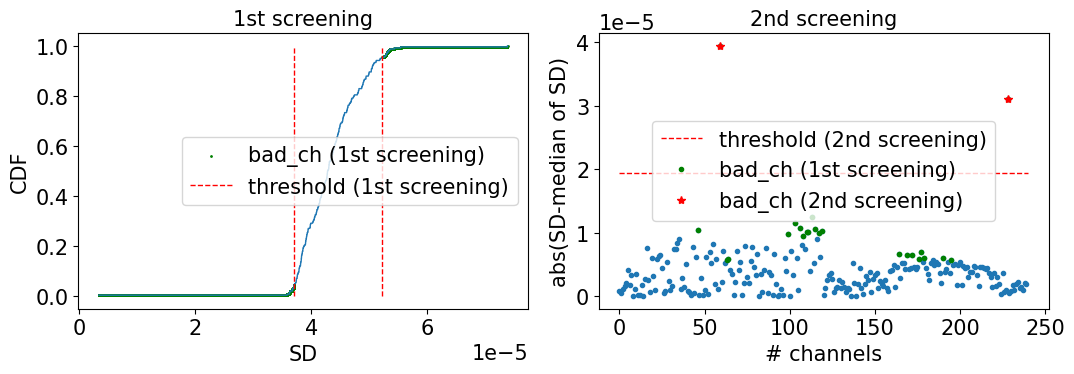

In [3]:
trial_filter = lambda t: REWARD in t
elec_pos, acq_ch, elecs = aopy.data.load_chmap(drive_type='ECoG244')

for idx, entry in enumerate(data_list):
    print(idx)
    exp_id = entry.id
    exp_date = entry.date.date()
    
    # Load data
    data, metadata = aopy.data.load_preproc_exp_data(preproc_dir, subject, exp_id, exp_date)
    lfp_data, lfp_metadata =  aopy.data.load_preproc_lfp_data(preproc_dir, subject, exp_id, exp_date)
    cursor_traj_tmp, tsegs_tmp = aopy.data.get_kinematic_segments(preproc_dir, subject, exp_id, exp_date, CURSOR_ENTER_CENTER_TARGET, REWARD, trial_filter=trial_filter)
    eye_traj_tmp, tsegs_tmp = aopy.data.get_kinematic_segments(preproc_dir, subject, exp_id, exp_date, CURSOR_ENTER_CENTER_TARGET, REWARD, trial_filter=trial_filter, datatype='eye')
    cursor_traj_show_tmp, _ = aopy.data.get_kinematic_segments(preproc_dir, subject, exp_id, exp_date, CENTER_TARGET_OFF,REWARD, trial_filter=trial_filter)
    eye_traj_show_tmp, _ = aopy.data.get_kinematic_segments(preproc_dir,subject,exp_id,exp_date,CENTER_TARGET_OFF,REWARD,trial_filter=trial_filter,datatype='eye')

    _, times_tmp = aopy.preproc.base.get_trial_segments_and_times(data['events']['code'], data['events']['timestamp'],CURSOR_ENTER_CENTER_TARGET, REWARD)
    success_percent_tmp = aopy.analysis.calc_success_percent(data['events']['code'], CURSOR_ENTER_CENTER_TARGET, END_TRIAL_CODE, REWARD, window_size=success_rate_window)
    eye_data, eye_metadata = aopy.data.load_preproc_eye_data(preproc_dir, subject, exp_id, exp_date)
    target_idx_tmp = []
    target_idx_tmp = np.concatenate((target_idx_tmp, np.array([t[1] for t in tsegs_tmp])-CENTER_TARGET_ON))

    target_pos = aopy.data.get_target_locations(preproc_dir, subject, exp_id, exp_date, [0,1,2,3,4,5,6,7,8])
    
    # Collect metadata
    volt_bit = lfp_metadata['voltsperbit']
    FS_cursor = metadata['cursor_interp_samplerate']
    FS_hand = metadata['analog_samplerate']
    FS_eye = eye_metadata['samplerate']
    FS = lfp_metadata['lfp_samplerate']
    target_radius = metadata['target_radius']

    # bad channel detection
    lfp_data = lfp_data[:,acq_ch-1]*volt_bit
    if idx == 0:
        numsd_badch = 5
        bad_ch = aopy.preproc.quality.detect_bad_ch_outliers(lfp_data[:60*FS,:], nbins=10000, thr=0.05, numsd=numsd_badch, debug=True, verbose=True)
        good_ch =~bad_ch

    # FIR filter
    # order = 20000
    # Wn = [0.1,200]
    # fnq = FS/2
    # print('filtering...')
    # b = signal.firwin(order, Wn, nyq=fnq, pass_zero=False, window='hamming')
    # lfp_filter = signal.filtfilt(b, 1, lfp_data, axis=0)
    # np.save(f'/data/postprocessed/tomo/lfp_filter_{subject}_{exp_date}',lfp_filter)
    lfp_filter_tmp = np.load(f'/data/postprocessed/tomo/lfp_filter_{subject}_{exp_date}.npy')

    # Get task-related times
    ntr = len(cursor_traj_tmp)
    trial_start_tmp = np.array([t[0] for t in times_tmp])
    target_onset_tmp = np.array([t[1] for t in times_tmp])
    gocue_time_tmp = np.array([t[2] for t in times_tmp])
    acquire_time_tmp = np.array([t[3] for t in times_tmp])
    reward_time_tmp = np.array([t[4] for t in times_tmp])
    cursor_leave_from_trial_start = get_cursor_leave_center_time(cursor_traj_tmp, times_tmp, FS_cursor, target_radius)
    cursor_leave_time_tmp = np.array([cursor_leave_from_trial_start[itr] + times_tmp[itr][0] for itr in range(ntr)])
    
    movement_onset_tmp = detect_movement_onset(cursor_traj_tmp, FS_cursor, trial_start_tmp, target_onset_tmp, gocue_time_tmp,numsd=num_sd_mv)
    movement_onset_tmp = movement_onset_tmp + trial_start_tmp

    # Calc saccade onset
    saccades_onset_tmp,saccade_onset_tmp,duration_tmp,main_saccade_idx_tmp = [],[],[],[]
    for itr in range(len(eye_traj_tmp)):
        ave_eye_traj = np.stack([(eye_traj_tmp[itr][:,0]+eye_traj_tmp[itr][:,2])/2, (eye_traj_tmp[itr][:,1]+eye_traj_tmp[itr][:,3])/2]).T
        eye_data_filt = aopy.precondition.filter_eye(ave_eye_traj, FS_eye, downsamplerate=downsamplerate)
        
        # Compute threshold for saccade detection
        if (itr == 0) & (idx == 0):
            eye_accel = aopy.precondition.convert_pos_to_accel(eye_data_filt, downsamplerate)
            baseline_mean = np.mean(eye_accel)
            baseline_std = np.std(eye_accel)
            thr = np.mean(baseline_mean) + num_sd*baseline_std
            thr = (thr, -thr)
        
        #onset, duration1, distance1 = aopy.precondition.detect_saccades(eye_data_filt, downsamplerate, thr=thr, num_sd=num_sd)
        onset, duration1, distance1 = aopy.precondition.detect_saccades(eye_data_filt, downsamplerate, num_sd=num_sd)
        
        onset_pos, offset_pos = aopy.postproc.get_saccade_pos(ave_eye_traj, np.array(onset), np.array(duration1), downsamplerate)
        onset_target, offset_target = aopy.postproc.get_saccade_target_index(onset_pos, offset_pos, target_pos[:,:2], sac_radius)
        onset_event, offset_event = aopy.postproc.get_saccade_event(np.array(onset), np.array(duration1), times_tmp[itr]-times_tmp[itr][0], tsegs_tmp[itr])
        saccade_idx = get_main_saccade(onset_target, offset_target, onset_event, offset_event, target_idx_tmp[itr])
        
        onset += times_tmp[itr][0]
        duration_tmp.append(duration1)
        saccades_onset_tmp.append(onset)
        saccade_onset_tmp.append(onset[saccade_idx])
        main_saccade_idx_tmp.append(saccade_idx)
        
    saccade_onset_tmp = np.array(saccade_onset_tmp)
    saccades_onset_tmp = np.array(saccades_onset_tmp, dtype=object)
    duration_tmp = np.array(duration_tmp, dtype=object)
    main_saccade_idx_tmp = np.array(main_saccade_idx_tmp)
    
    # Calc trial_align_data
    if flag == 'gocue':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, gocue_time_tmp, time_before, time_after, FS)
        flag_name = 'gocue'
    elif flag == 'saccade':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, saccade_onset_tmp, time_before, time_after, FS)
        flag_name = 'saccade onset'
    elif flag == 'target':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, target_onset_tmp, time_before, time_after, FS)
        flag_name = 'target onset'
    elif flag == 'acquire':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, acquire_time_tmp, time_before, time_after, FS)
        flag_name = 'acquire'
    elif flag == 'cursor_leave':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, cursor_leave_time_tmp, time_before, time_after, FS)
        flag_name = 'cursor_leave'
    elif flag == 'movement':
        trial_align_data_tmp = aopy.preproc.trial_align_data(lfp_filter_tmp, movement_onset_tmp, time_before, time_after, FS)
        flag_name = 'movement'
    else:
        print('Use different flag name')
    trial_align_data_tmp = trial_align_data_tmp.transpose(2,0,1)
    
    # Concatenate trials across days
    if idx == 0:
        trial_align_data = trial_align_data_tmp
        trial_start = trial_start_tmp
        target_onset = target_onset_tmp
        gocue_time = gocue_time_tmp
        reward_time = reward_time_tmp
        movement_onset = movement_onset_tmp
        saccade_onset = saccade_onset_tmp
        acquire_time = acquire_time_tmp
        cursor_leave_time = cursor_leave_time_tmp
        success_percent = success_percent_tmp
        target_idx = target_idx_tmp
        cursor_traj = cursor_traj_tmp
        cursor_traj_show = cursor_traj_show_tmp
        eye_traj = eye_traj_tmp
        eye_traj_show = eye_traj_show_tmp
        saccades_onset = saccades_onset_tmp
        duration = duration_tmp
        times = times_tmp
        tsegs = tsegs_tmp
        main_saccade_idx = main_saccade_idx_tmp
        lfp_filter = lfp_filter_tmp

    else:
        trial_align_data = np.concatenate([trial_align_data, trial_align_data_tmp], axis=0)
        lfp_filter = np.concatenate([lfp_filter, lfp_filter_tmp],axis=0)
        trial_start = np.concatenate([trial_start, trial_start_tmp])
        target_onset = np.concatenate([target_onset, target_onset_tmp])
        gocue_time = np.concatenate([gocue_time, gocue_time_tmp])
        reward_time = np.concatenate([reward_time, reward_time_tmp])
        movement_onset = np.concatenate([movement_onset, movement_onset_tmp])
        saccade_onset = np.concatenate([saccade_onset, saccade_onset_tmp])
        saccades_onset = np.concatenate([saccades_onset, saccades_onset_tmp])
        duration = np.concatenate([duration, duration_tmp])
        acquire_time = np.concatenate([acquire_time, acquire_time_tmp])
        cursor_leave_time = np.concatenate([cursor_leave_time, cursor_leave_time_tmp])
        success_percent = np.concatenate([success_percent, success_percent_tmp])
        target_idx = np.concatenate([target_idx, target_idx_tmp])
        cursor_traj = np.concatenate([cursor_traj, cursor_traj_tmp])
        cursor_traj_show = np.concatenate([cursor_traj_show, cursor_traj_show_tmp])
        eye_traj = np.concatenate([eye_traj, eye_traj_tmp])
        eye_traj_show = np.concatenate([eye_traj_show, eye_traj_show_tmp])
        times = np.concatenate([times, times_tmp])
        tsegs = np.concatenate([tsegs, tsegs_tmp])
        main_saccade_idx = np.concatenate([main_saccade_idx, main_saccade_idx_tmp])
        
trial_align_data = trial_align_data[:,:,good_ch]
elec_pos = elec_pos[good_ch]
acq_ch = acq_ch[good_ch]
ntr,nt,nch = trial_align_data.shape

normal_saccade_trial = main_saccade_idx != -1
print(normal_saccade_trial.sum()/normal_saccade_trial.shape[0])

In [4]:
# load spectral power data
target_list = [1,2,3,4,5,6,7,8]
ntarget = len(target_list)

bands = [(0.1,4),(4,8),(8,14),(14,30),(30,80),(80,150)]
nband = len(bands)
band_name = ['delta','theta','alpha','beta','gamma','hgamma']
NW = 0.5
BW = 4 # the number of taper is (2*nw*bw-1)
t_axis = np.linspace(-time_before,time_after,nt)

flag = 'gocue'
NW = 0.5
BW = 4
loaded_data = np.load(f'/data/postprocessed/tomo/{subject}_{flag}_{NW}_{BW}_{str(exp_date)}_fir-filt.npz')
f_spec = loaded_data['f_spec']
t_spec = loaded_data['t_spec']
spec_band = loaded_data['spec_band']
print(f'{subject}_{flag}_{NW}_{BW}_{str(exp_date)}_fir-filt.npz')

beignet_gocue_0.5_4_2022-06-28_fir-filt.npz


In [5]:
# Compute relevant saccade and reasonable movement onset trials
target_idx = np.array([t[1]-CENTER_TARGET_ON for t in tsegs])

saccades_onset,saccade_onset,duration,main_saccade_idx = [],[],[],[]
for itr in range(len(eye_traj)):
    ave_eye_traj = np.stack([(eye_traj[itr][:,0]+eye_traj[itr][:,2])/2, (eye_traj[itr][:,1]+eye_traj[itr][:,3])/2]).T
    eye_data_filt = aopy.precondition.filter_eye(ave_eye_traj, FS_eye, downsamplerate=downsamplerate)

    onset, duration1, distance1 = aopy.precondition.detect_saccades(eye_data_filt, downsamplerate, num_sd=num_sd)

    onset_pos, offset_pos = aopy.postproc.get_saccade_pos(ave_eye_traj, np.array(onset), np.array(duration1), downsamplerate)
    onset_target, offset_target = aopy.postproc.get_saccade_target_index(onset_pos, offset_pos, target_pos[:,:2], sac_radius)
    onset_event, offset_event = aopy.postproc.get_saccade_event(np.array(onset), np.array(duration1), times[itr]-times[itr][0], tsegs[itr])
    saccade_idx = get_main_saccade(onset_target, offset_target, onset_event, offset_event, target_idx[itr])

    onset += times[itr][0]
    duration.append(duration1)
    saccades_onset.append(onset)
    saccade_onset.append(onset[saccade_idx])
    main_saccade_idx.append(saccade_idx)

saccade_onset = np.array(saccade_onset)
saccades_onset = np.array(saccades_onset, dtype=object)
duration = np.array(duration, dtype=object)
main_saccade_idx = np.array(main_saccade_idx)

# get trials with relevant saccades
normal_saccade_trial = main_saccade_idx != -1

# get trials with reasonable movement onset
movement_onset_go = movement_onset - gocue_time
normal_onset_time = movement_onset_go > 0.15

# Decoding analysis

In [23]:
alignment_flag = 'acquire' # which alignment you use in decoding
target_idx = np.array([t[1]-CENTER_TARGET_ON for t in tsegs])

# Times relative to gocue
target_on_go = target_onset - gocue_time
saccade_onset_go = saccade_onset - gocue_time
cursor_leave_go = cursor_leave_time - gocue_time
acquire_go = acquire_time - gocue_time
reward_go = reward_time - gocue_time

if alignment_flag == 'target':
    t_center = target_on_go
    win = [0.1,0.2]
elif alignment_flag == 'gocue':
    t_center = np.zeros(ntr)
    win = [-0.05,0.05]
elif alignment_flag == 'saccade':
    t_center = saccade_onset_go
    win = [-0.05,0.05]
elif alignment_flag == 'movement':
    t_center = movement_onset_go
    win = [-0.05,0.05]
elif alignment_flag == 'cursor_leave':   
    t_center = cursor_leave_go
    win = [-0.05,0.05]
elif alignment_flag == 'acquire':   
    t_center = acquire_go
    win = [-0.05,0.05]
elif alignment_flag == 'reward':   
    t_center = reward_go
    win = [-0.05,0.05]

# z scoring
z_spec_band = (spec_band - np.mean(spec_band, axis=(0,2),keepdims=True))/(np.std(spec_band, axis=(0,2),keepdims=True,ddof=1))

# Get bad trials
bad_tr = []
for itr in range(ntr):
    time_win = (t_spec >= t_center[itr] + win[0])*(t_spec <= t_center[itr] + win[1])
    itr_data = z_spec_band[[itr],:,:,:]
    tmp = np.mean(itr_data[:,:,time_win,:],axis=2)
    if sum(time_win)==0:
        bad_tr.append(itr)
    if itr == 0:
        z_data_win = tmp
    else:
        z_data_win = np.concatenate([z_data_win, tmp],axis=0)
        
bad_tr = np.array(bad_tr)
print(bad_tr)
if bad_tr.size>0:
    bad_tr_mask = np.zeros(ntr,dtype=bool)
    bad_tr_mask[bad_tr] = True
    good_tr_mask = ~bad_tr_mask
else:
    good_tr_mask = np.ones(ntr,dtype=bool)

trial_restrict_mask = normal_saccade_trial * normal_onset_time * good_tr_mask

/home/aolab/miniconda3/envs/tomo-analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aolab/miniconda3/envs/tomo-analysis/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[224 272 438 447]


In [24]:
band_idx = -1 # which band you focus
nbs = 300 # number of bootstrapping
n_splits = 5 # number of cross validation
shuffle = False # whether to shuffle target index for permutation test

y_pred_bs = []
y_true_bs = []
weights_bs = []
print(f'{alignment_flag}')
z_single_win = z_data_win[:,[band_idx],:]

min_trial = get_minimum_trials_per_target(target_idx, trial_restrict_mask)
print(min_trial)

for i_bs in tqdm(range(nbs)):
    np.random.seed(i_bs)
    
    # Get trial label with replacement for bootstrapping
    trial_mask = get_conditioned_trials_per_target(target_idx, trial_restrict_mask, min_trial, replacement=True, seed=i_bs)
    trial_mask = np.random.permutation(trial_mask)
    
    # Get data for LDA
    data_win = z_single_win[trial_mask,:,:]
    cond_label = target_idx[trial_mask]
    if shuffle:
        cond_label = np.random.permutation(cond_label)
    
    # Average score (spatial filtering)
    y_pred, y_true, weights = classify_targ_lda2(data_win, cond_label, n_splits)
    y_pred_bs.append(y_pred)
    y_true_bs.append(y_true)
    weights_bs.append(weights)
    
y_pred_bs = np.array(y_pred_bs, 'object')
y_true_bs = np.array(y_true_bs, 'object')
weights_bs = np.array(weights_bs, 'object')

np.savez(f'/data/postprocessed/tomo/Neuropixel_targeting/{subject}_decoding_{alignment_flag}_numbs{nbs}_shuffle_{shuffle}_{band_name[band_idx]}', y_pred_bs=y_pred_bs, y_true_bs=y_true_bs, weights_bs=weights_bs)

acquire
66


  0%|          | 0/300 [00:00<?, ?it/s]

In [42]:
# load bootstrapping data
nbs = 300
n_splits = 5
band_idx = -1
alignment_flag = 'acquire'
loaded_data = np.load(f'/data/postprocessed/tomo/Neuropixel_targeting/{subject}_decoding_{alignment_flag}_numbs{nbs}_shuffle_{shuffle}_{band_name[band_idx]}.npz',allow_pickle=True)
y_pred_bs = loaded_data['y_pred_bs']
y_true_bs = loaded_data['y_true_bs']
weights_bs = loaded_data['weights_bs']

In [43]:
accuracy_ch = np.zeros((nbs, nch))
for ibs in tqdm(range(nbs)):
    for ich in range(nch):
        
        accuracy_fold = []
        for ifold in range(n_splits):
            accuracy_fold.append(accuracy_score(y_true_bs[ibs][ich][ifold], y_pred_bs[ibs][ich][ifold]))
        
        accuracy_ch[ibs,ich] = np.mean(accuracy_fold)
        
m_accuracy_bs = np.mean(accuracy_ch,axis=0)

  0%|          | 0/300 [00:00<?, ?it/s]

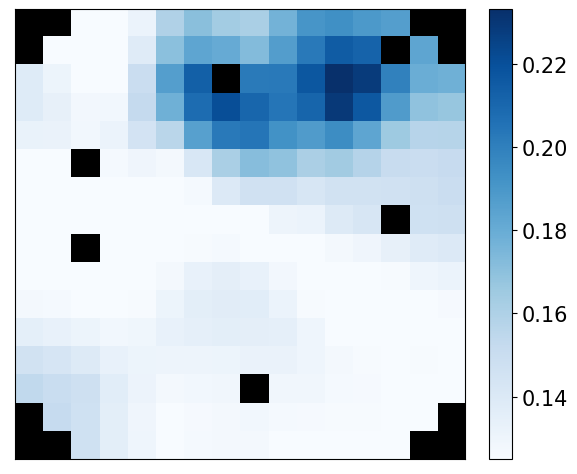

In [44]:
# Average accuracy across neighboring channels
m_accuracy_ch = np.zeros(nch)
dist = aopy.utils.calc_euclid_dist_mat(elec_pos)
for ich in range(dist.shape[0]):
    ave_idx = (dist[:,ich] <= 1.3)#0.75, 1.3
    m_accuracy_ch[ich] = np.nanmean(m_accuracy_bs[ave_idx])   

# Show data
fig,ax=plt.subplots(figsize=(7,5),tight_layout=True)
xy = [elec_pos[:,0], elec_pos[:,1]]
da_map = aopy.visualization.get_data_map(m_accuracy_ch,xy[0],xy[1])
da_map[0,0],da_map[0,1],da_map[1,0],da_map[0,-1],da_map[0,-2],da_map[1,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
da_map[-1,0],da_map[-1,1],da_map[-2,0],da_map[-1,-1],da_map[-1,-2],da_map[-2,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
im = aopy.visualization.plot_spatial_map(da_map, xy[0], xy[1], ax=ax, cmap='Blues')
im.norm.vmin = 1/8
im.norm.vmax = np.nanmax(m_accuracy_ch)

cbar = fig.colorbar(im, ax=ax, orientation='vertical',fraction=0.046, pad=0.04)
ax.set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[])
fig.show()
np.savez(f'/data/postprocessed/tomo/Neuropixel_targeting/{subject}_{alignment_flag}_decoding_accuracy_{band_name[band_idx]}', da=m_accuracy_ch, elec_pos=elec_pos)

In [17]:
alignment_list = ['gocue','movement','acquire']
nalignment = len(alignment_list)
band_idx = 0
shuffle=False

accuracy_alignment = np.zeros((nalignment,nbs, nch))
for idx, alignment_flag in enumerate(alignment_list):
    loaded_data = np.load(f'/data/postprocessed/tomo/Neuropixel_targeting/{subject}_decoding_{alignment_flag}_numbs{nbs}_shuffle_{shuffle}_{band_name[band_idx]}.npz',allow_pickle=True)
    y_pred_bs = loaded_data['y_pred_bs']
    y_true_bs = loaded_data['y_true_bs']
    #weights_bs = loaded_data['weights_bs']

    for ibs in tqdm(range(nbs)):
        for ich in range(nch):
            
            accuracy_fold = []
            for ifold in range(n_splits):
                accuracy_fold.append(accuracy_score(y_true_bs[ibs][ich][ifold], y_pred_bs[ibs][ich][ifold]))
                
            accuracy_alignment[idx,ibs,ich] = np.mean(accuracy_fold)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

/home/aolab/miniconda3/envs/tomo-analysis/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/aolab/miniconda3/envs/tomo-analysis/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


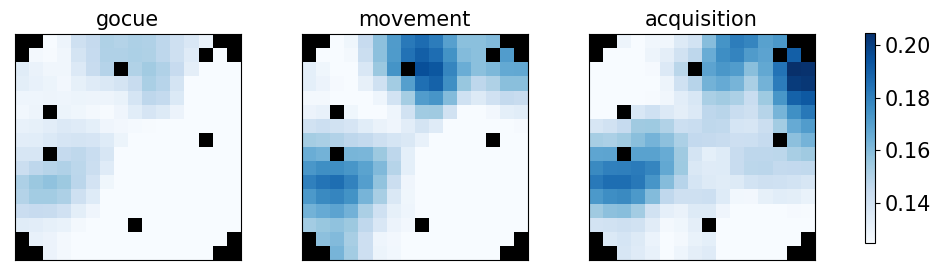

In [18]:
alignment_list = ['gocue','movement','acquisition']
dist = aopy.utils.calc_euclid_dist_mat(elec_pos)
xy = [elec_pos[:,0], elec_pos[:,1]]
m_accuracy_bs = np.mean(accuracy_alignment,axis=1) # mean across bootstrapping samples

# Average accuracy across neighboring channels
m_accuracy_ch = np.zeros((nalignment,nch))
for ich in range(dist.shape[0]):
    ave_idx = (dist[:,ich] <= 1.3)#0.75, 1.3
    m_accuracy_ch[:,ich] = np.nanmean(m_accuracy_bs[:,ave_idx],axis=1)   

fig,ax=plt.subplots(ncols=nalignment,figsize=(9,3),tight_layout=True)
for idx in range(nalignment):
    da_map = aopy.visualization.get_data_map(m_accuracy_ch[idx,:],xy[0],xy[1])
    da_map[0,0],da_map[0,1],da_map[1,0],da_map[0,-1],da_map[0,-2],da_map[1,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    da_map[-1,0],da_map[-1,1],da_map[-2,0],da_map[-1,-1],da_map[-1,-2],da_map[-2,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    im = aopy.visualization.plot_spatial_map(da_map, xy[0], xy[1], ax=ax[idx], cmap='Blues')
    im.norm.vmin = 1/8
    im.norm.vmax = np.nanmax(m_accuracy_ch)
    ax[idx].set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[],title=f'{alignment_list[idx]}')


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1., 0.15, 0.011, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical',fraction=0.046, pad=0.04)
fig.show()

# Contralateral and ipsilateral target decoding

In [56]:
## Show decoding accuracy in different time windows
target_idx = np.array([t[1]-CENTER_TARGET_ON for t in tsegs])
alignment_flag = 'reward'
n_splits = 5

# Aligne timings
target_on_go = target_onset - gocue_time
saccade_onset_go = saccade_onset - gocue_time
cursor_leave_go = cursor_leave_time - gocue_time
reward_go = reward_time - gocue_time

# Prepare data
if alignment_flag == 'target':
    t_center = target_on_go
    win = [0.1,0.2]
elif alignment_flag == 'gocue':
    t_center = np.zeros(ntr)
    win = [-0.05,0.05]
elif alignment_flag == 'saccade':
    t_center = saccade_onset_go
    win = [-0.05,0.05]
elif alignment_flag == 'movement':
    t_center = movement_onset_go
    win = [-0.05,0.05]
elif alignment_flag == 'cursor_leave':   
    t_center = cursor_leave_go
    win = [-0.05,0.05]
elif alignment_flag == 'reward':   
    t_center = reward_go
    win = [-0.05,0.05]

# Preprocess data
#z_spec_band = stats.zscore(spec_band,axis=2)   
z_spec_band = (spec_band - np.mean(spec_band, axis=(0,2),keepdims=True))/(np.std(spec_band, axis=(0,2),keepdims=True,ddof=1))

bad_tr = []
for itr in range(ntr):
    time_win = (t_spec >= t_center[itr] + win[0])*(t_spec <= t_center[itr] + win[1])
    itr_data = z_spec_band[[itr],:,:,:]
    tmp = np.mean(itr_data[:,:,time_win,:],axis=2)
    if sum(time_win)==0:
        bad_tr.append(itr)
    if itr == 0:
        z_data_win = tmp
    else:
        z_data_win = np.concatenate([z_data_win, tmp],axis=0)

bad_tr2 = []
for itr in range(z_spec_band.shape[0]):
    if np.any(np.isnan(z_spec_band[itr,:,:])):
        bad_tr2.append(itr)

bad_tr = np.concatenate([bad_tr,bad_tr2])
bad_tr = np.array([int(a) for a in bad_tr])
print(bad_tr)

if bad_tr.size>0:
    bad_tr_mask = np.zeros(ntr,dtype=bool)
    bad_tr_mask[bad_tr] = True
    good_tr_mask = ~bad_tr_mask
else:
    good_tr_mask = np.ones(ntr,dtype=bool)

trial_restrict_mask = normal_saccade_trial * normal_onset_time * good_tr_mask

/home/aolab/miniconda3/envs/tomo-analysis/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aolab/miniconda3/envs/tomo-analysis/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[224 272 288 317 438 447]


In [57]:
decoding_flag = 'contra'
shuffle = False
nbs = 300
band_idx = -1

y_pred_bs = []
y_true_bs = []
weights_bs = []

z_single_win = z_data_win[:,[band_idx],:]
print(f'{alignment_flag}')

if decoding_flag == 'contra':
    partial_target = [2,3,4]
else:
    partial_target = [6,7,8]

# get minimum number of trials for each target in both contralateral and ipsilateral targets  
contra_ipsi_target_mask = (target_idx == 2)|(target_idx == 3)|(target_idx == 4)|(target_idx == 6)|(target_idx == 7)|(target_idx == 8)
contra_ipsi_cond_mask = trial_restrict_mask * contra_ipsi_target_mask
min_trial = get_minimum_trials_per_target(target_idx[contra_ipsi_cond_mask], contra_ipsi_cond_mask[contra_ipsi_cond_mask])
print(min_trial)

# mask for conditioning trials
lateral_mask = (target_idx == partial_target[0])|(target_idx == partial_target[1])|(target_idx == partial_target[2])
cond_mask = trial_restrict_mask*lateral_mask

for i_bs in tqdm(range(nbs)):
    np.random.seed(i_bs)
    
    # Get trial label with replacement for bootstrapping
    trial_mask = get_conditioned_trials_per_target(target_idx, cond_mask, min_trial, replacement=True, seed=i_bs)
    
    # Get data for LDA
    data_win = z_single_win[trial_mask,:,:]
    cond_label = target_idx[trial_mask]
    if shuffle:
        cond_label = np.random.permutation(cond_label)
        
    # Average score (spatial filtering)
    y_pred, y_true, weights = classify_targ_lda2(data_win, cond_label, n_splits)
    y_pred_bs.append(y_pred)
    y_true_bs.append(y_true)
    weights_bs.append(weights)
    
y_pred_bs = np.array(y_pred_bs, 'object')
y_true_bs = np.array(y_true_bs, 'object')
weights_bs = np.array(weights_bs, 'object')

np.savez(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_{decoding_flag}_numbs{nbs}_shuffle_{shuffle}_{band_name[band_idx]}', \
    y_pred_bs=y_pred_bs, y_true_bs=y_true_bs, weights_bs=weights_bs)

#############################################################
##### Ipsilateral decoding
#############################################################

decoding_flag = 'ipsi'
y_pred_bs = []
y_true_bs = []
weights_bs = []
print(f'{alignment_flag}')

if decoding_flag == 'contra':
    partial_target = [2,3,4]
else:
    partial_target = [6,7,8]

# get minimum number of trials for each target in both contralateral and ipsilateral targets  
contra_ipsi_target_mask = (target_idx == 2)|(target_idx == 3)|(target_idx == 4)|(target_idx == 6)|(target_idx == 7)|(target_idx == 8)
contra_ipsi_cond_mask = trial_restrict_mask * contra_ipsi_target_mask
min_trial = get_minimum_trials_per_target(target_idx[contra_ipsi_cond_mask], contra_ipsi_cond_mask[contra_ipsi_cond_mask])
print(min_trial)

# mask for conditioning trials
lateral_mask = (target_idx == partial_target[0])|(target_idx == partial_target[1])|(target_idx == partial_target[2])
cond_mask = trial_restrict_mask*lateral_mask

for i_bs in tqdm(range(nbs)):
    np.random.seed(i_bs)
    
    # Get trial label with replacement for bootstrapping
    trial_mask = get_conditioned_trials_per_target(target_idx, cond_mask, min_trial, replacement=True, seed=i_bs)
    
    # Get data for LDA
    data_win = z_single_win[trial_mask,:,:]
    cond_label = target_idx[trial_mask]
    if shuffle:
        cond_label = np.random.permutation(cond_label)
        
    # Average score (spatial filtering)
    y_pred, y_true, weights = classify_targ_lda2(data_win, cond_label, n_splits)
    y_pred_bs.append(y_pred)
    y_true_bs.append(y_true)
    weights_bs.append(weights)
    
y_pred_bs = np.array(y_pred_bs, 'object')
y_true_bs = np.array(y_true_bs, 'object')
weights_bs = np.array(weights_bs, 'object')

np.savez(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_{decoding_flag}_numbs{nbs}_shuffle_{shuffle}_{band_name[band_idx]}', \
    y_pred_bs=y_pred_bs, y_true_bs=y_true_bs, weights_bs=weights_bs)

reward
66


  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
# Contralateral and ipsilateral accuracy
nbs = 300
alignment_list = ['movement','reward']
nalignment = len(alignment_list)
band_idx = -1

accuracy_alignment = np.zeros((4, nalignment, nbs, nch))
for idx, alignment_flag in enumerate(alignment_list):
    loaded_data = np.load(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_contra_numbs{nbs}_shuffle_False_{band_name[band_idx]}.npz',allow_pickle=True)
    y_pred_bs_contra = loaded_data['y_pred_bs']
    y_true_bs_contra = loaded_data['y_true_bs']

    loaded_data = np.load(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_contra_numbs{nbs}_shuffle_True_{band_name[band_idx]}.npz',allow_pickle=True)
    y_pred_bs_contra_shuffle = loaded_data['y_pred_bs']
    y_true_bs_contra_shuffle = loaded_data['y_true_bs']
        
    loaded_data = np.load(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_ipsi_numbs{nbs}_shuffle_False_{band_name[band_idx]}.npz',allow_pickle=True)
    y_pred_bs_ipsi = loaded_data['y_pred_bs']
    y_true_bs_ipsi = loaded_data['y_true_bs']

    loaded_data = np.load(f'/data/postprocessed/tomo/{subject}_decoding_{alignment_flag}_ipsi_numbs{nbs}_shuffle_True_{band_name[band_idx]}.npz',allow_pickle=True)
    y_pred_bs_ipsi_shuffle = loaded_data['y_pred_bs']
    y_true_bs_ipsi_shuffle = loaded_data['y_true_bs']
        
    for ibs in tqdm(range(nbs)):
        for ich in range(nch):
            
            accuracy_fold_contra = []
            accuracy_fold_ipsi = []
            accuracy_fold_contra_shuffle = []
            accuracy_fold_ipsi_shuffle = []
            for ifold in range(n_splits):
                accuracy_fold_contra.append(accuracy_score(y_true_bs_contra[ibs][ich][ifold], y_pred_bs_contra[ibs][ich][ifold]))
                accuracy_fold_ipsi.append(accuracy_score(y_true_bs_ipsi[ibs][ich][ifold], y_pred_bs_ipsi[ibs][ich][ifold]))
                accuracy_fold_contra_shuffle.append(accuracy_score(y_true_bs_contra_shuffle[ibs][ich][ifold], y_pred_bs_contra_shuffle[ibs][ich][ifold]))
                accuracy_fold_ipsi_shuffle.append(accuracy_score(y_true_bs_ipsi_shuffle[ibs][ich][ifold], y_pred_bs_ipsi_shuffle[ibs][ich][ifold]))
                
            accuracy_alignment[0,idx,ibs,ich] = np.mean(accuracy_fold_contra)
            accuracy_alignment[1,idx,ibs,ich] = np.mean(accuracy_fold_ipsi)
            accuracy_alignment[2,idx,ibs,ich] = np.mean(accuracy_fold_contra_shuffle)
            accuracy_alignment[3,idx,ibs,ich] = np.mean(accuracy_fold_ipsi_shuffle)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [46]:
alpha = 0.95
dist = aopy.utils.calc_euclid_dist_mat(elec_pos)
xy = [elec_pos[:,0], elec_pos[:,1]]
m_accuracy_bs = np.mean(accuracy_alignment,axis=2) # mean across bootstrapping samples

# Compute significance
not_significant_contra = np.zeros((nalignment,nch),dtype='bool')
for idx in range(nalignment):
    confidence_contra = []
    for ich in range(nch):
        count, bins_count = np.histogram(accuracy_alignment[2,idx,:,ich], bins=50)
        bin_edge = bins_count[1:] - np.diff(bins_count)[0]
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        confidence_contra.append(bin_edge[np.where(cdf<alpha)[0][-1]])
    confidence_contra = np.array(confidence_contra) # nch array
    not_significant_contra[idx,:] = confidence_contra > m_accuracy_bs[0,idx,:]

not_significant_ipsi = np.zeros((nalignment,nch),dtype='bool')
for idx in range(nalignment):
    confidence_ipsi = []
    for ich in range(nch):
        count, bins_count = np.histogram(accuracy_alignment[3,idx,:,ich], bins=50)
        bin_edge = bins_count[1:] - np.diff(bins_count)[0]
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        confidence_ipsi.append(bin_edge[np.where(cdf<alpha)[0][-1]])
    confidence_ipsi = np.array(confidence_ipsi) # nch array
    not_significant_ipsi[idx,:] = confidence_ipsi > m_accuracy_bs[1,idx,:]
    
not_significant = not_significant_contra# + not_significant_ipsi
print(not_significant.shape)

# TODO add another criteria to remove channels

(2, 238)


/home/aolab/miniconda3/envs/tomo-analysis/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/aolab/miniconda3/envs/tomo-analysis/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


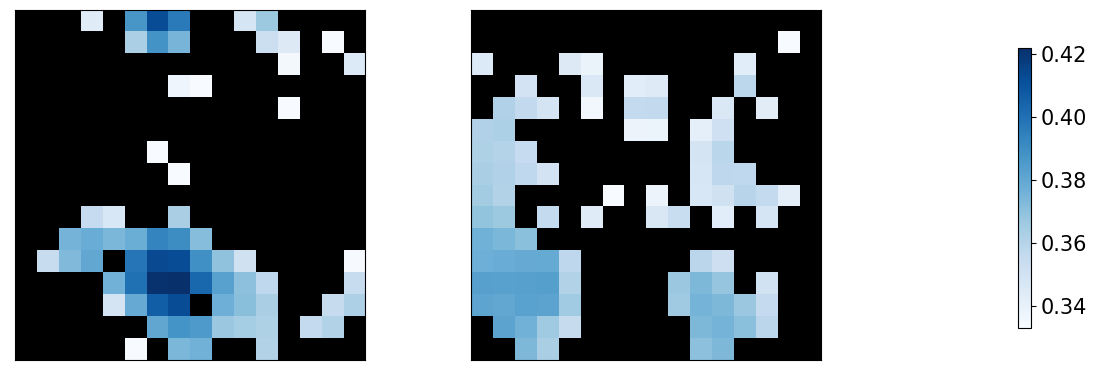

In [53]:
ipsi_idx = 0
dist = aopy.utils.calc_euclid_dist_mat(elec_pos)
xy = [elec_pos[:,0], elec_pos[:,1]]
m_accuracy_bs = np.mean(accuracy_alignment[ipsi_idx,:,:,:],axis=1) # mean across bootstrapping samples

# Compute significance
# not_significant_ch = np.zeros((nalignment,nch),dtype='bool')
# for idx in range(nalignment):
#     significance = []
#     for ich in range(nch):
#         count, bins_count = np.histogram(accuracy_alignment[ipsi_idx,idx,:,ich], bins=50)
#         bin_edge = bins_count[1:] - np.diff(bins_count)[0]
#         pdf = count / sum(count)
#         cdf = np.cumsum(pdf)
#         significance.append(bin_edge[np.where(cdf<0.05)[0][-1]])
#     significance = np.array(significance) # nch array
#     not_significant_ch[idx,:]  = 1/3 > significance
#     m_accuracy_bs[idx,not_significant_ch[idx,:]] = np.nan

m_accuracy_ch = np.zeros((nalignment,nch))
for ich in range(dist.shape[0]):
    ave_idx = (dist[:,ich] <= 1.3)#0.75, 1.3
    m_accuracy_ch[:,ich] = np.nanmean(m_accuracy_bs[:,ave_idx],axis=1)   

fig,ax=plt.subplots(ncols=nalignment,figsize=(12,4),tight_layout=True)
for idx in range(nalignment):
    m_accuracy_ch[idx,not_significant_contra[idx,:]] = np.nan
    da_map = aopy.visualization.get_data_map(m_accuracy_ch[idx,:],xy[0],xy[1])
    da_map[0,0],da_map[0,1],da_map[1,0],da_map[0,-1],da_map[0,-2],da_map[1,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    da_map[-1,0],da_map[-1,1],da_map[-2,0],da_map[-1,-1],da_map[-1,-2],da_map[-2,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    im = aopy.visualization.plot_spatial_map(da_map, xy[0], xy[1], ax=ax[idx], cmap='Blues')
    im.norm.vmin = 1/3
    im.norm.vmax = np.nanmax(m_accuracy_ch)

    #ax[ii].set(title=f'{center_list[ii]*1000} ms',xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[])
    ax[idx].set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[])


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1., 0.15, 0.011, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical',fraction=0.046, pad=0.04)
#fig.colorbar(im, cax=cbar_ax)

fig.show()

(2, 238)


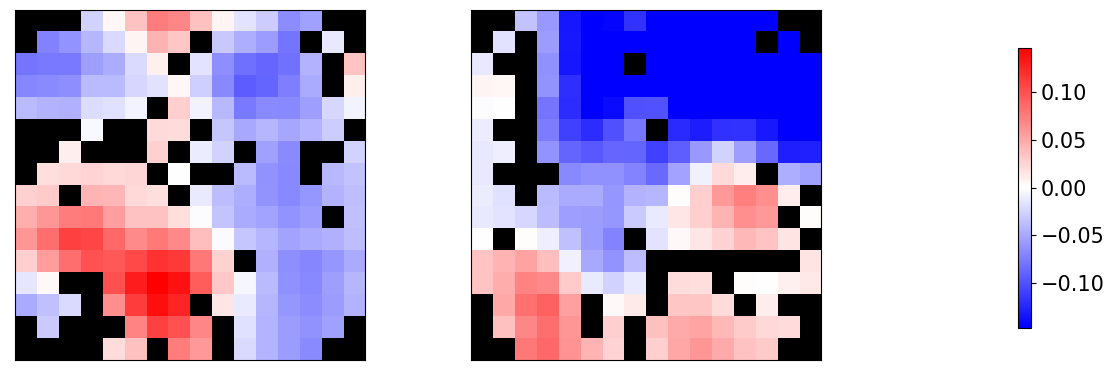

In [55]:
#accuracy_alignment[0,idx,ibs,ich] = np.mean(accuracy_fold_contra)
#accuracy_alignment[1,idx,ibs,ich] = np.mean(accuracy_fold_ipsi)

lateral_idx_bs = (accuracy_alignment[0,:,:,:] - accuracy_alignment[1,:,:,:])/(accuracy_alignment[0,:,:,:] + accuracy_alignment[1,:,:,:])
lateral_idx = np.mean(lateral_idx_bs,axis=1)

not_significant_diff = np.zeros((nalignment,nch),dtype=bool)
for idx in range(nalignment):
    for ich in range(nch):  
        _, p = stats.ranksums(accuracy_alignment[0,idx,:,ich],accuracy_alignment[1,idx,:,ich])
        not_significant_diff[idx,ich] = p > 0.01
        
print(lateral_idx.shape)
m_lateral_idx = np.zeros(lateral_idx.shape)
for ich in range(dist.shape[0]):
    ave_idx = (dist[:,ich] <= 1.3)#0.75, 1.3
    m_lateral_idx[:,ich] = np.nanmean(lateral_idx[:,ave_idx],axis=1)
    
fig,ax=plt.subplots(ncols=nalignment,figsize=(12,4),tight_layout=True)
for idx in range(nalignment):
    #m_lateral_idx[idx,not_significant_contra[idx,:]] = np.nan
    m_lateral_idx[idx,not_significant_diff[idx,:]] = np.nan
    da_map = aopy.visualization.get_data_map(m_lateral_idx[idx,:],xy[0],xy[1])
    da_map[0,0],da_map[0,1],da_map[1,0],da_map[0,-1],da_map[0,-2],da_map[1,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    da_map[-1,0],da_map[-1,1],da_map[-2,0],da_map[-1,-1],da_map[-1,-2],da_map[-2,-1] = np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    im = aopy.visualization.plot_spatial_map(da_map, xy[0], xy[1], ax=ax[idx], cmap='bwr')
    im.norm.vmin = -np.nanmax(m_lateral_idx)
    im.norm.vmax = np.nanmax(m_lateral_idx)
    ax[idx].set(xlabel='',ylabel='',xticks=[],xticklabels=[],yticks=[],yticklabels=[])
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([1., 0.15, 0.011, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical',fraction=0.046, pad=0.04)